<a href="https://colab.research.google.com/github/lucas-fpaiva/AnalisePred_I/blob/main/Projeto/car_eval/classifier_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Avaliar se o preço de compra do veículo é aceitável


In [74]:
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

from scipy.io.arff import loadarff 
from scipy.io import arff

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import precision_score as ps
from sklearn.metrics import recall_score as rs
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import auc, roc_auc_score


from sklearn.metrics import plot_confusion_matrix

from sklearn.datasets import make_classification
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')


In [96]:
def grid_best_model (model="DT", names=False, grid=""):
  #A função retorna o modelo com os melhores parametros, os melhores parametros e o melhor score
  scoring = 'accuracy'

  if names == True:
    print("LM: LinearRegression\nKNN: KNeighborsClassifier\nMLPClassifier\nDT: DecisionTreeClassifier\nRF: RandomForestClassifier",
          "\nSVC: SupportVectorMachineClassifier\nBNB: BernoulliNaiveBayes\nADA: AdaBoostClassifier\nGB: GradientBoostingClassifier\n")
    
  if model == "DT":
    gs_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid['DT'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return DecisionTreeClassifier(**gs_cv.best_params_).fit(x_treino, y_treino), gs_cv.best_params_
      
  if model=="MLP":
    gs_cv = GridSearchCV(estimator=MLPClassifier(), param_grid=grid['MLP'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return MLPClassifier(**gs_cv.best_params_), gs_cv.best_params_
    
  if model == "RF":
    gs_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid['RF'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return RandomForestClassifier(**gs_cv.best_params_), gs_cv.best_params_

  if model == "KNN":
    gs_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid['KNN'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return KNeighborsClassifier(**gs_cv.best_params_), gs_cv.best_params_

  if model == "LM":
    gs_cv = GridSearchCV(estimator=LogisticRegression(), param_grid=grid['LM'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return LogisticRegression(**gs_cv.best_params_), gs_cv.best_params_

  if model == "BNB":
    gs_cv = GridSearchCV(estimator=BernoulliNB(), param_grid=grid['BNB'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return BernoulliNB(**gs_cv.best_params_).fit(x_treino, y_treino), gs_cv.best_params_

  if model == "SVC":
    gs_cv = GridSearchCV(estimator=SVC(), param_grid=grid['SVC'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return SVC(**gs_cv.best_params_).fit(x_treino, y_treino), gs_cv.best_params_

  if model == "GBC":
    gs_cv = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=grid['GBC'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return GradientBoostingClassifier(**gs_cv.best_params_).fit(x_treino, y_treino), gs_cv.best_params_
        
  return print("LM: LinearRegression\nKNN: KNeighborsClassifier\nMLPClassifier\nDT: DecisionTreeClassifier\nRF: RandomForestClassifier",
              "\nSVC: SupportVectorMachineClassifier\nBNB: BernoulliNaiveBayes\nADA: AdaBoostClassifier\nGB: GradientBoostingClassifier\n")
  
#Parâmetros do Grid
grid = {
    'RF':{ 
        'n_estimators': [100],
        'max_depth' : range(5,30,2),
        'criterion' :['gini', 'entropy'],
        'random_state' : [0]},

    'MLP':{
        'hidden_layer_sizes': range(5,30,2),
        'max_iter': [200],
        'activation' : ['relu', 'tanh'],
        'random_state' : [0]},

    'DT':{
        'max_depth': range(5,30,2),
        'min_samples_leaf': [1,2,3,4,5],
        'criterion' :['gini', 'entropy'],
        'random_state' : [0]},

    'KNN':{
        'n_neighbors': range(5,30,2),
        'weights': ['uniform', 'distance'],
        'metric' : ['manhattan', 'euclidean']},

    'LM':{
        'fit_intercept' : [True, False],
        'random_state' : [0]},

    'BNB':{
        'alpha' : np.arange(0.0, 1.0, 0.1)},
    
    'SVC':{
        'kernel' : ['linear', 'rbf'],
        'max_iter' : [-1, 1, 2],
        'class_weight' : ['None', 'balanced'],
        'random_state' : [0]},
    
    'GBC':{
        'n_estimators': [100],
        'max_depth' : range(5,30,2),#[3], 
        'random_state' : [0]}
}

In [40]:
def data_k_fold(data, k, tag, id_tag, features):
    kf=StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
    kf.get_n_splits(data[tag].values)
    ids = np.array(data[id_tag])
    folds = pd.DataFrame([], columns=[id_tag, 'fold'])
    k=1
    
    for train_index, test_index in kf.split(data[features], data[tag]):
      fold = np.array([k]*len(test_index))
      folds = pd.concat([folds, pd.DataFrame(np.transpose([ids[test_index],fold]),columns=[id_tag, 'fold'])])
      k+=1

    data = data.merge(folds, how='left',on=id_tag)   
    return data

In [79]:
def metrics (y_true, y_pred, y_pred_prob):
  return [acs(y_true, y_pred), ps(y_true, y_pred, average = 'weighted'), f1(y_true, y_pred, average = 'weighted'),
          rs(y_true, y_pred, average = 'weighted'), roc_auc_score(y_true, y_pred_prob, average = 'weighted', multi_class = 'ovr')]

## Lendo o Dataset

In [42]:
!git clone 'https://github.com/lucas-fpaiva/AnalisePred_I.git'

fatal: destination path 'AnalisePred_I' already exists and is not an empty directory.


In [55]:
data = loadarff('/content/AnalisePred_I/Projeto/car_eval/car-evaluation.arff')
data = pd.DataFrame(data[0])

# Convertendo os valores em bytes para int
for col in data.columns:
    data[col] = data[col].astype(int)

data['id'] = data.index
features = data.columns[1:-1]
data = data_k_fold(data, 5, 'class', 'id', features)


In [ ]:
data.to_csv("data_processed.csv")

In [56]:
data = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/AnalisePred_I/main/Projeto/car_eval/data_processed.csv', index_col=0)
features = data.columns[1:-1]

In [44]:
data.head()

,class,buying_price_vhigh,buying_price_high,buying_price_med,buying_price_low,maintenance_price_vhigh,maintenance_price_high,maintenance_price_med,maintenance_price_low,doors_2,...,persons_4,persons_more,luggage_boot_size_small,luggage_boot_size_med,luggage_boot_size_big,safety_low,safety_med,safety_high,id,fold
0,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,5
1,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,1,5
2,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,2,5
3,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,3,4
4,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,4,2


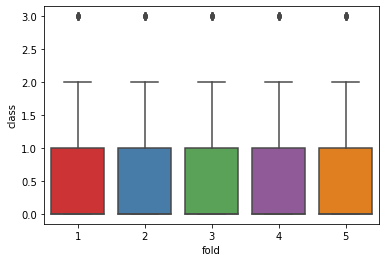

In [45]:
sns.boxplot(data = data, y='class',x='fold',palette='Set1')

## Avaliando a Árvore de Decisão

In [ ]:
data_results = pd.DataFrame([],columns=['accuracy', 'precision', 'f1_score','recall', 'auc', 'fold','model','parameters'])
models = ["LM", "KNN", "MLP", "DT", "RF", "BNB", "SVC", "GBC"]

for name_model in models:
  results = []
  for k in range(1,6):
    treino = data[data.fold!=k]
    teste  = data[data.fold==k]
    
    x_treino = treino[features]
    y_treino = treino['class']

    x_teste = teste[features]
    y_teste = teste['class']

    model, best_parameters = grid_best_model(model=name_model, grid=grid)
    model.fit(x_treino, y_treino)
    y_pred= model.predict(x_teste)
    y_pred_prob = model.predict_proba(x_teste)

    print("Modelo:", name_model)
    print("Melhor parametro:", best_parameters)         
    print("Fold", k, metrics(y_teste.values, y_pred, y_pred_prob))

    plt.figure()
    plot_confusion_matrix(model, x_teste, y_teste)
    plt.title(name_model+'_f'+ str(k))
    plt.savefig('/content/drive/MyDrive/AnalisePred_I/confusion_matrix/'+ name_model+'_f'+ str(k) +'.pdf', format="pdf", dpi=1000, bbox_inches="tight")

    result = metrics(y_teste, y_pred, y_pred_prob)
    result.append(k)
    result.append(name_model)
    result.append(best_parameters)
    
    results.append(result)
        
  data_results = pd.concat([data_results, pd.DataFrame(results,columns=['accuracy', 'precision', 'f1_score','recall', 'auc', 'fold','model','parameters'])])
  data_results.to_csv('/content/drive/MyDrive/AnalisePred_I/Car_results_'+ name_model + '.csv')


Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 1 [0.8815028901734104, 0.8749685850716261, 0.872208430917565, 0.8815028901734104, 0.9842292419400387]
Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 2 [0.9161849710982659, 0.9188381726141418, 0.9129899548974694, 0.9161849710982659, 0.9889393159313634]
Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 3 [0.8786127167630058, 0.8830473182671598, 0.8774770215080528, 0.8786127167630058, 0.9771141921815172]
Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 4 [0.9014492753623189, 0.9017523917779671, 0.8995234144992598, 0.9014492753623189, 0.9832696422680953]
Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 5 [0.8956521739130435, 0.9033692555431685, 0.8932749506948043, 0.8956521739130435, 0.9868406619709863]
Modelo: KNN
Melhor parametro: {'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}
F

In [95]:
data_results.mean()

accuracy     0.978015
precision    0.978306
f1_score     0.977815
recall       0.978015
auc          0.998886
fold         3.000000
dtype: float64

### Predição do Modelo

In [27]:
model.fit(x_treino, y_treino)
np.sqrt(model.score(x_treino, y_treino))

0.9631684276912472

In [28]:
model.score(x_teste, y_teste)

0.9217391304347826

In [29]:
y_pred_t = model.predict(x_treino)

In [30]:
y_pred= model.predict(x_teste)

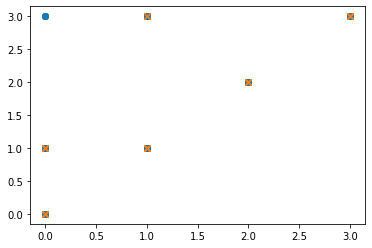

In [31]:
plt.plot(y_treino, y_pred_t, 'o')

plt.plot(y_teste, y_pred, 'x')


#### MAPE

In [ ]:
mape(y_teste,y_pred)*100

nan

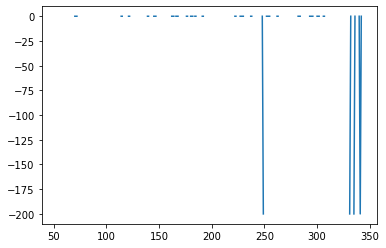

In [32]:
plt.plot(((y_teste.values - y_pred)/y_teste.values)*100)
np.mean(100*np.abs(y_teste.values - y_pred)/y_teste.values)

#### Plot do Modelo Teste x Treino

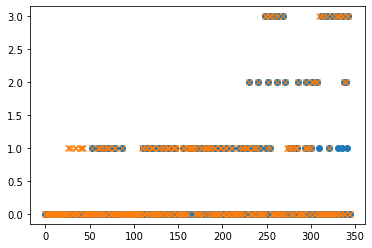

In [34]:
plt.plot(y_teste.values, 'o')
plt.plot(y_pred, 'x')

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.00001))) * 100

In [ ]:
def mae (y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def r2_score(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))